In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
dates = os.listdir("/media/ubuntu/sda/data/mouse6/output_grating/num_threshold/5000")

cluster_inf = pd.DataFrame()
spike_inf = pd.DataFrame()
waveform_mean = pd.DataFrame()

for date in dates:
    cluster_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output_grating/num_threshold/5000/{date}/cluster_inf.tsv', sep = '\t').iloc[:, 1:]
    cluster_inf_temp['date'] = date
    cluster_inf = pd.concat((cluster_inf, cluster_inf_temp), axis= 0)

    spike_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output_grating/num_threshold/5000/{date}/spike_inf.tsv', sep = "\t").iloc[:, 1:]
    spike_inf_temp['date'] = date
    spike_inf = pd.concat((spike_inf, spike_inf_temp), axis=0)

    waveform_mean_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output_grating/num_threshold/5000/{date}/waveform_mean.tsv', sep = "\t").iloc[:, 1:]
    waveform_mean_temp.columns = waveform_mean_temp.columns + f"_{date}"
    waveform_mean = pd.concat((waveform_mean, waveform_mean_temp), axis=1)


del waveform_mean_temp, spike_inf_temp, cluster_inf_temp

In [3]:
dates = os.listdir("/media/ubuntu/sda/data/mouse6/output/threshold_number_test/5000")

for date in dates:
    cluster_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/threshold_number_test/5000/{date}/cluster_inf.tsv', sep = '\t').iloc[:, 1:]
    cluster_inf_temp['date'] = f'{date}_NI'
    cluster_inf = pd.concat((cluster_inf, cluster_inf_temp), axis= 0)

    spike_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/threshold_number_test/5000/{date}/spike_inf.tsv', sep = "\t").iloc[:, 1:]
    spike_inf_temp['date'] = f'{date}_NI'
    spike_inf = pd.concat((spike_inf, spike_inf_temp), axis=0)

    waveform_mean_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse6/output/threshold_number_test/5000/{date}/waveform_mean.tsv', sep = "\t").iloc[:, 1:]
    waveform_mean_temp.columns = waveform_mean_temp.columns + f"_{date}_NI"
    waveform_mean = pd.concat((waveform_mean, waveform_mean_temp), axis=1)


del waveform_mean_temp, spike_inf_temp, cluster_inf_temp

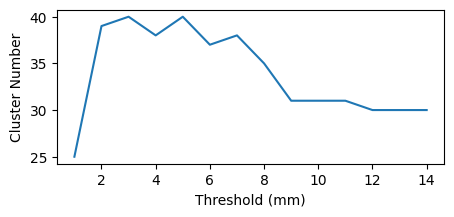

In [4]:
threshold = np.arange(1, 15, 1)
num_neuron = []
for num in threshold:
    cluster_inf['Neuron'] = None
    cluster_inf.iloc[0, 28] = 1
    neuron_inf = pd.DataFrame(cluster_inf.iloc[0, :]).T
    neuron = 1
    for i in range(1, len(cluster_inf)):
        found = False
        for j in range(len(neuron_inf)):
            if (abs(cluster_inf.iloc[i, 22] - neuron_inf.iloc[j, 22]) <= num) and (abs(cluster_inf.iloc[i, 23] - neuron_inf.iloc[j, 23]) <= num):
                cluster_inf.iloc[i, 28] = neuron_inf.iloc[j, 28]
                found = True
                break
        if not found:
            neuron += 1
            cluster_inf.iloc[i,28] = neuron
            neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_inf.iloc[i, :]).T), axis=0)

    neurons_with_count_gt_16 = cluster_inf['Neuron'].value_counts()
    neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()
    num_neuron.append(len(neuron_values))

plt.figure(figsize=(5, 2))
sns.lineplot(x = threshold,
                y = num_neuron)
plt.xlabel("Threshold (mm)")
plt.ylabel("Cluster Number")
plt.show()

In [4]:
num = 5
cluster_inf['Neuron'] = None
spike_inf['Neuron'] = None
cluster_inf.iloc[0, 28] = 1
neuron_inf = pd.DataFrame(cluster_inf.iloc[0, :]).T
neuron = 1
for i in range(1, len(cluster_inf)):
    found = False
    for j in range(len(neuron_inf)):
        if (abs(cluster_inf.iloc[i, 22] - neuron_inf.iloc[j, 22]) <= num) and (abs(cluster_inf.iloc[i, 23] - neuron_inf.iloc[j, 23]) <= num):
            cluster_inf.iloc[i, 28] = neuron_inf.iloc[j, 28]
            found = True
            break
    if not found:
        neuron += 1
        cluster_inf.iloc[i,28] = neuron
        neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_inf.iloc[i, :]).T), axis=0)

neurons_with_count_gt_16 = cluster_inf['Neuron'].value_counts()
neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()

num = 1
neuron_cluster_dict = {}
for neuron in neuron_values:
    temp = cluster_inf[cluster_inf['Neuron'] == neuron]
    filter_cluster = temp.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
    waveform_mean_temp = waveform_mean.loc[:, filter_cluster]

    from sklearn.cluster import DBSCAN
    from sklearn.decomposition import PCA


    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(waveform_mean_temp.T)

    eps = 100
    min_samples = 1

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(principal_components)

    #plt.Figure(figsize=(5, 5))
    #sns.scatterplot(x = principal_components[:, 0],
    #            y = principal_components[:, 1],
    #            hue=dbscan.labels_)
    #plt.title(neuron)
    #plt.show()

    filter_cluster = pd.DataFrame(filter_cluster).reset_index(drop=True)
    filter_cluster = pd.concat((pd.DataFrame(filter_cluster), pd.DataFrame(dbscan.labels_)), axis=1)
    filter_cluster.columns = ['cluster_date', 'dbscan_labels']
    for i in filter_cluster['dbscan_labels'].value_counts().index:
        neuron_cluster_dict[f'Neuron_{num}'] = filter_cluster.loc[filter_cluster['dbscan_labels'] == i, 'cluster_date'].tolist()
        num += 1

neuron_cluster_dict = {key: value for key, value in neuron_cluster_dict.items() if len(set([item.split('_')[1] for item in value])) >= 13}
cluster_inf['cluster_date'] = cluster_inf.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
cluster_inf = cluster_inf[cluster_inf['cluster_date'].isin([item for sublist in neuron_cluster_dict.values() for item in sublist])]
for key, item in neuron_cluster_dict.items():
    cluster_inf.loc[cluster_inf['cluster_date'].isin(item), 'Neuron'] = key 

spike_inf['cluster_date'] = spike_inf.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
spike_inf = spike_inf[spike_inf['cluster_date'].isin([item for sublist in neuron_cluster_dict.values() for item in sublist])]
for key, item in neuron_cluster_dict.items():
    spike_inf.loc[spike_inf['cluster_date'].isin(item), 'Neuron'] = key 

cluster_inf['Neuron_index'] = cluster_inf['Neuron'].str.extract(r'Neuron_(\d+)').astype(int)
cluster_inf = cluster_inf.sort_values(by='Neuron_index')
cluster_inf['Neuron'] = 'Neuron_' + (cluster_inf['Neuron_index'].rank(method='dense').astype(int)).astype(str)


spike_inf['Neuron_index'] = spike_inf['Neuron'].str.extract(r'Neuron_(\d+)').astype(int)
spike_inf = spike_inf.sort_values(by='Neuron_index')
spike_inf['Neuron'] = 'Neuron_' + (spike_inf['Neuron_index'].rank(method='dense').astype(int)).astype(str)

cluster_inf['neuron_date'] = cluster_inf.apply(lambda row: f"{row['Neuron']}_{row['date']}", axis=1)
spike_inf['neuron_date'] = spike_inf.apply(lambda row: f"{row['Neuron']}_{row['date']}", axis=1)

from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
with PdfPages('cluster_view_5000_all.pdf') as pdf:
    for neuron in sorted(cluster_inf['Neuron'].unique(), key=lambda x: int(x.split('_')[1])):
        temp = cluster_inf[cluster_inf['Neuron'] == neuron]
        waveform_mean_temp = waveform_mean.loc[:, temp['cluster_date'].tolist()]

        similarity = np.zeros((waveform_mean_temp.shape[1], waveform_mean_temp.shape[1]))
        for i in range(waveform_mean_temp.shape[1]):
            for j in range(waveform_mean_temp.shape[1]):
                similarity[i, j], _ = pearsonr(waveform_mean_temp.iloc[:, i], waveform_mean_temp.iloc[:, j])
        similarity = similarity.flatten()

        cluster_num = len(temp['neuron_date'].value_counts().index)
        blue_palette = sns.color_palette("Blues", n_colors=waveform_mean_temp.shape[1])

        fig, ax = plt.subplots(figsize=(6, 4))
        for i in range(waveform_mean_temp.shape[1]):
            sns.lineplot(x = range(61),
                        y = waveform_mean_temp.iloc[:, i],
                        color=blue_palette[i],
                        ax=ax)
        axins = inset_axes(ax, width="20%", height="30%", loc='lower right', bbox_to_anchor=(-0.03, 0.05, 1, 1), bbox_transform=ax.transAxes)    
        sns.histplot(similarity, color='red', ax=axins, edgecolor = None)
        axins.set_yticks([])
        axins.set_ylabel("")
        axins.set_title("Similarity", fontsize=9)
        axins.tick_params(axis='both', which='major', labelsize=8)

        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(neuron)
        ax.text(0.01, 0.95, f'Cluster Number: {cluster_num}', transform=ax.transAxes, fontsize=10, color='black', ha='left')
        pdf.savefig(fig)
        plt.close(fig)


In [17]:
with PdfPages('cluster_view_5000_all.pdf') as pdf:
    for neuron in sorted(cluster_inf['Neuron'].unique(), key=lambda x: int(x.split('_')[1])):
        temp = cluster_inf[cluster_inf['Neuron'] == neuron]
        waveform_mean_temp = waveform_mean.loc[:, temp['cluster_date'].tolist()]

        # 计算相似性矩阵
        similarity = np.zeros((waveform_mean_temp.shape[1], waveform_mean_temp.shape[1]))
        for i in range(waveform_mean_temp.shape[1]):
            for j in range(waveform_mean_temp.shape[1]):
                similarity[i, j], _ = pearsonr(waveform_mean_temp.iloc[:, i], waveform_mean_temp.iloc[:, j])
        similarity_flat = similarity.flatten()

        cluster_num = len(temp['neuron_date'].value_counts().index)
        blue_palette = sns.color_palette("Blues", n_colors=waveform_mean_temp.shape[1])

        # 创建主图（相关性直方图）
        fig, ax = plt.subplots(figsize=(4, 2.5))
        
        # 绘制主图：相关性分布直方图
        sns.histplot(similarity_flat, 
                    bins=20, 
                    stat='density',
                    color='red', 
                    edgecolor=None,
                    ax=ax)
        ax.set_xlim(0, 1)
        ax.set_xlabel("Correlation")
        ax.set_ylabel("Density")
        ax.set_title(neuron)
        
        # 设置稀疏y轴刻度
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))  # 限制最多4个刻度
        
        # 添加cluster number标注
        ax.text(0.01, 0.93, 
               f'Cluster Number: {cluster_num}', 
               transform=ax.transAxes, 
               fontsize=10, 
               color='black', 
               ha='left')

        # 创建嵌入图（波形图）
        axins = inset_axes(ax, 
                          width="85%", 
                          height="85%", 
                          loc='center',
                          borderpad=0)
        
        # 绘制波形图
        for i in range(waveform_mean_temp.shape[1]):
            sns.lineplot(x=range(61),
                         y=waveform_mean_temp.iloc[:, i],
                         color=blue_palette[i],
                         ax=axins,
                         linewidth=1)
        
        # 移除嵌入图坐标轴
        axins.set_xticks([])
        axins.set_yticks([])
        axins.set_xlabel("")
        axins.set_ylabel("")
        [axins.spines[s].set_visible(False) for s in axins.spines]

        pdf.savefig(fig)
        plt.close(fig)

In [7]:
date_order = ['021322', '022522', '031722', '042422', 
              '052422', '062422', '072322', '082322', 
              '092422', '102122', '112022', '122022', 
              '012123', '022223', '032123', '042323']